#Training data:  80
#Testing data :  20
Class labels: [-1  1]


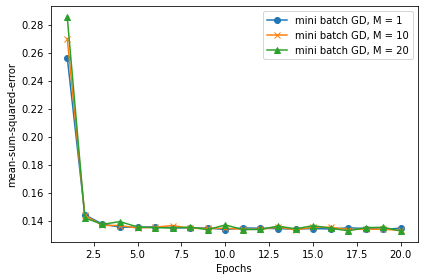

M=1, Misclassified samples: 3
M=1, Accuracy: 0.85
M=10, Misclassified samples: 3
M=10, Accuracy: 0.85
M=20, Misclassified samples: 3
M=20, Accuracy: 0.85


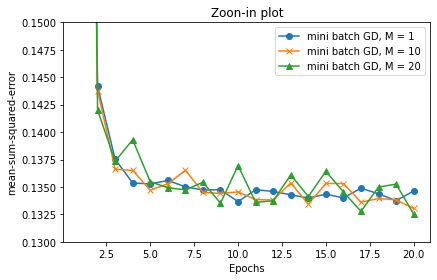

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

seed = np.random.seed

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data: ', X_train.shape[0])
print('#Testing data : ', X_test.shape[0])
print('Class labels: %s' % np.unique(y))

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, batch_size=45):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.batch_size = batch_size
        if random_state: seed(random_state)

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for batch in self.iterate_minibatches(X, y, self.batch_size):
                x_batch, y_batch = batch
                # print(x_batch.shape, y_batch.shape)
                cost.append(self._update_weights(x_batch, y_batch))
            # print(len(y))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)

        # Cost function
        error = (yi - output)
        cost = 0.5*(error**2).sum()

        # Update rule
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()

        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

    def iterate_minibatches(self, inputs, targets, batchsize):
        assert inputs.shape[0] == targets.shape[0]
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
        for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
            excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]



adas1 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=1)
adas1.fit(X_train_std, y_train)

adas10 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=10)
adas10.fit(X_train_std, y_train)

adas20 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=20)
adas20.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, marker='o', label='mini batch GD, M = 1')
plt.plot(range(1, len(adas10.cost_) + 1), adas10.cost_, marker='x', label='mini batch GD, M = 10')
plt.plot(range(1, len(adas20.cost_) + 1), adas20.cost_, marker='^', label='mini batch GD, M = 20')

plt.xlabel('Epochs')
plt.ylabel('mean-sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig-adaline-sgd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred1 = adas1.predict(X_test_std)
print('M=1, Misclassified samples: %d' % (y_test != y_pred1).sum())
print('M=1, Accuracy: %.2f' % accuracy_score(y_test, y_pred1))

y_pred2 = adas10.predict(X_test_std)
print('M=10, Misclassified samples: %d' % (y_test != y_pred2).sum())
print('M=10, Accuracy: %.2f' % accuracy_score(y_test, y_pred2))

y_pred3 = adas20.predict(X_test_std)
print('M=20, Misclassified samples: %d' % (y_test != y_pred3).sum())
print('M=20, Accuracy: %.2f' % accuracy_score(y_test, y_pred3))




#Plot Zoom in
plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, marker='o', label='mini batch GD, M = 1')
plt.plot(range(1, len(adas10.cost_) + 1), adas10.cost_, marker='x', label='mini batch GD, M = 10')
plt.plot(range(1, len(adas20.cost_) + 1), adas20.cost_, marker='^', label='mini batch GD, M = 20')

plt.xlabel('Epochs')
plt.ylabel('mean-sum-squared-error')
plt.legend(loc='upper right')

plt.title('Zoon-in plot')
plt.tight_layout()
plt.savefig('fig-adaline-sgd-cost_zoomin.png', dpi=300)
plt.ylim([0.13,0.15])
plt.show()

